### DATA PREPROCESSING

#### About the Dataset

This dataset contains faces extracted from deepfake-detection-challenge. All images were of size 224x224. 

Due to memory issue we will only use a sample of the entire dataset for prediction.

#### Importing Required libraries

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import shutil
import os

In [2]:
import plotly.graph_objs as go
from plotly.offline import iplot
from matplotlib import pyplot as plt

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [4]:
tf.__version__

'2.12.0'

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [21]:
# pip install cmake
# pip install dlib
# pip install face_recognition

<b> FAKE DATA PREPROCESSING: </b> <br>

In [6]:
fake_directory = r'reduced_dataset\fake'
fake_folders = []
for foldername in os.listdir(fake_directory):
    folder = os.path.join(fake_directory,foldername)
    fake_folders.append(folder)

print("Folders in specified path:")
for folder in fake_folders:
    print(os.path.normpath(folder))

Folders in specified path:
reduced_dataset\fake\ekhacizpah_mp4
reduced_dataset\fake\ekkdjkirzq_mp4
reduced_dataset\fake\elginszwtk_mp4
reduced_dataset\fake\elvvackpjh_mp4
reduced_dataset\fake\emaalmsonj_mp4
reduced_dataset\fake\emfbhytfhc_mp4
reduced_dataset\fake\emgjphonqb_mp4
reduced_dataset\fake\ensyyivobf_mp4
reduced_dataset\fake\eoewqcpbgt_mp4
reduced_dataset\fake\eprybmbpba_mp4
reduced_dataset\fake\epymyyiblu_mp4
reduced_dataset\fake\eqjscdagiv_mp4
reduced_dataset\fake\eqvuznuwsa_mp4
reduced_dataset\fake\erqgqacbqe_mp4
reduced_dataset\fake\errocgcham_mp4
reduced_dataset\fake\esckbnkkvb_mp4
reduced_dataset\fake\esgftaficx_mp4
reduced_dataset\fake\esnntzzajv_mp4
reduced_dataset\fake\esxrvsgpvb_mp4
reduced_dataset\fake\esyhwdfnxs_mp4


Cropping the images from each fake data subfolder → cropped_fake_set

In [51]:
fake_directory_cropped = 'reduced_dataset\cropped_fake_set'
if not os.path.exists(fake_directory_cropped):
   # Create a new directory because it does not exist
   os.makedirs(fake_directory_cropped)

for folder in fake_folders:
    path = os.path.normpath(folder)
    modified_path = path.replace('fake','cropped_fake_set')
    if not os.path.exists(modified_path):
      # Create a new directory because it does not exist
      os.makedirs(modified_path)


In [7]:
import face_recognition
from PIL import Image

def process_face(path, check, face_id):
    image = face_recognition.load_image_file(path)

    face_locations = face_recognition.face_locations(image)
    print("faces:", len(face_locations))

    if len(face_locations) != 1:
        return # ignore uncertain cases

    for face_location in face_locations:

        # Print the location of each face in this image
        top, right, bottom, left = face_location

        # You can access the actual face itself like this:
        face = image[top:bottom, left:right]


        face_img = Image.fromarray(face)
        if (check):
            print(path)
            modified_path = path.replace('fake','cropped_fake_set')
            # modified_path = path.replace('fake','cropped_fake')
        else:
            modified_path = path.replace('real','cropped_real_set')
            # modified_path = path.replace('real','cropped_real')
        
        modified_path = modified_path[:48] + "face_"+ str(face_id) +".jpg"
        face_img.save(modified_path)
        print(modified_path)


In [ ]:
face_id = 0 
for folder in fake_folders:
    for images in os.listdir(folder):
        if (images.endswith(".jpg")):
                face_id +=1
                process_face(f'{folder}\{images}', True, face_id)

Extracting 30 frames from each cropped_fake_set subfolder and consolidating all those frames together  → cropped_fake_consolidated

In [30]:
cropped_fake_consolidated = 'reduced_dataset\cropped_fake_consolidated'
if not os.path.exists(cropped_fake_consolidated):
   # Create a new directory because it does not exist
   os.makedirs(cropped_fake_consolidated)

for folder in fake_folders:  # Go over each folder path
    folder = folder.replace('fake', 'cropped_fake_set')
    files = os.listdir(folder)  # Get filenames in current folder
    num_files = min(len(files), 30)  # Choose either 30 or len(files), whichever is smaller
    files = random.sample(files, num_files)  # Pick 30 random files
    files = sorted(files, key=lambda x: int(x.split('_')[1].split('.')[0]))
   
    for file in files:  # Go over each file name to be deleted
        old_file = os.path.join(folder, file)
        new_file = os.path.join(cropped_fake_consolidated, file)  # Create valid path to file
        shutil.copy(old_file, new_file)

In [31]:
consolidated_fake_files = os.listdir(cropped_fake_consolidated)
consolidated_fake_images = len([f for f in consolidated_fake_files if f.endswith('.jpg')])
print('Total number of images in the folder:', consolidated_fake_images )

Total number of images in the folder: 540


Augmenting 30 frames from each cropped_fake_consolidated folder into 5 different variations  → cropped_fake_augmented

In [32]:
cropped_fake_augmented = 'reduced_dataset\cropped_fake_augmented'
if not os.path.exists(cropped_fake_augmented):
   # Create a new directory because it does not exist
   os.makedirs(cropped_fake_augmented)

In [33]:
import os
from PIL import Image
import torchvision.transforms as transforms

count = 1
for file in consolidated_fake_files:
    image_path = os.path.join(cropped_fake_consolidated, file)
    image = Image.open(image_path)
    augtransforms=transforms.Compose([transforms.Resize((150,150)),
                                      transforms.RandomAffine(degrees=(-30,30),translate=(0.1,0.1),shear=(-10,10)),
                                      transforms.RandomResizedCrop((150,150),scale=(0.8,1),ratio=(0.9,1.1)),
                                      transforms.RandomHorizontalFlip()])

    for i in range(5):
        new_image = augtransforms(image)
        save_path = os.path.join(cropped_fake_augmented,'face_' + str(count) + '.jpg')
        new_image.save(save_path)
        count +=1


In [34]:
augmented_fake_files = os.listdir('reduced_dataset\cropped_fake_augmented')
augmented_fake_images = len([f for f in augmented_fake_files if f.endswith('.jpg')])
print('Total number of images in the folder:', augmented_fake_images)


Total number of images in the folder: 2700


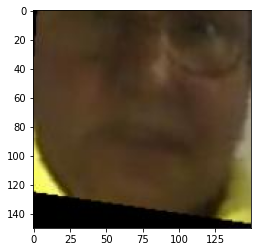

In [35]:
import glob
import matplotlib.pyplot as plt

for filename in glob.glob('reduced_dataset/cropped_fake_augmented/face_501.jpg'): 
    img=Image.open(filename)
    imgplot = plt.imshow(img)
    plt.show()

<b> REAL DATA PREPROCESSING: </b> <br>


Repeating the same steps for the real image dataset

In [20]:
real_directory = r'reduced_dataset\real'
real_folders = []
for foldername in os.listdir(real_directory):
    folder = os.path.join(real_directory,foldername)
    real_folders.append(folder)

print("Folders in specified path:")
for folder in real_folders:
    print(os.path.normpath(folder))

Folders in specified path:
reduced_dataset\real\bmjzrlszhi_mp4
reduced_dataset\real\bpapbctoao_mp4
reduced_dataset\real\brwrlczjvi_mp4
reduced_dataset\real\bulkxhhknf_mp4
reduced_dataset\real\bwhlgysghg_mp4
reduced_dataset\real\bwipwzzxxu_mp4
reduced_dataset\real\bxzakyopjf_mp4
reduced_dataset\real\bzythlfnhq_mp4
reduced_dataset\real\caifxvsozs_mp4
reduced_dataset\real\ccfoszqabv_mp4
reduced_dataset\real\cfxkpiweqt_mp4
reduced_dataset\real\chtapglbcj_mp4
reduced_dataset\real\chviwxsfhg_mp4
reduced_dataset\real\ciyoudyhly_mp4
reduced_dataset\real\cizlkenljw_mp4
reduced_dataset\real\ckjaibzfxa_mp4


Cropping the images from each real data subfolder → cropped_real_set

In [21]:
real_directory_cropped = 'reduced_dataset\cropped_real_set'
if not os.path.exists(real_directory_cropped):
   # Create a new directory because it does not exist
   os.makedirs(real_directory_cropped)

for folder in real_folders:
    path = os.path.normpath(folder)
    modified_path = path.replace('real','cropped_real_set')
    if not os.path.exists(modified_path):
      # Create a new directory because it does not exist
      os.makedirs(modified_path)

In [ ]:
face_id = 0 
for folder in real_folders:
    for images in os.listdir(folder):
        if (images.endswith(".jpg")):
                face_id +=1
                process_face(f'{folder}\{images}', False, face_id)

Extracting 30 frames from each cropped_real_set subfolder and consolidating all those frames together  → cropped_real_consolidated

In [36]:
cropped_real_consolidated = 'reduced_dataset\cropped_real_consolidated'
if not os.path.exists(cropped_real_consolidated):
   # Create a new directory because it does not exist
   os.makedirs(cropped_real_consolidated)

for folder in real_folders:  # Go over each folder path
    folder = folder.replace('real', 'cropped_real_set')
    files = os.listdir(folder)  # Get filenames in current folder
    num_files = min(len(files), 30)  # Choose either 30 or len(files), whichever is smaller
    files = random.sample(files, num_files)  # Pick 30 random files
    files = sorted(files, key=lambda x: int(x.split('_')[1].split('.')[0]))
   
    for file in files:  # Go over each file name to be deleted
        old_file = os.path.join(folder, file)
        new_file = os.path.join(cropped_real_consolidated, file)  # Create valid path to file
        shutil.copy(old_file, new_file)

In [37]:
consolidated_real_files = os.listdir(cropped_real_consolidated)
consolidated_real_images = len([f for f in consolidated_real_files if f.endswith('.jpg')])
print('Total number of images in the folder:', consolidated_real_images)

Total number of images in the folder: 480


Augmenting 30 frames from each cropped_real_consolidated folder into 5 different variations  → cropped_real_augmented

In [38]:
cropped_real_augmented = 'reduced_dataset\cropped_real_augmented'
if not os.path.exists(cropped_real_augmented):
   # Create a new directory because it does not exist
   os.makedirs(cropped_real_augmented)

In [39]:
count = 0
for file in consolidated_real_files:
    image_path = os.path.join(cropped_real_consolidated, file)
    image = Image.open(image_path)
    augtransforms=transforms.Compose([transforms.Resize((150,150)),
                                      transforms.RandomAffine(degrees=(-30,30),translate=(0.1,0.1),shear=(-10,10)),
                                      transforms.RandomResizedCrop((150,150),scale=(0.8,1),ratio=(0.9,1.1)),
                                      transforms.RandomHorizontalFlip()])

    for i in range(5):
        new_image = augtransforms(image)
        save_path = os.path.join(cropped_real_augmented,'face_' + str(count) + '.jpg')
        new_image.save(save_path)
        count +=1

In [40]:
augmented_real_files = os.listdir('reduced_dataset\cropped_real_augmented')
augmented_real_images = len([f for f in augmented_real_files if f.endswith('.jpg')])
print('Total number of images in the folder:', augmented_real_images)

Total number of images in the folder: 2400


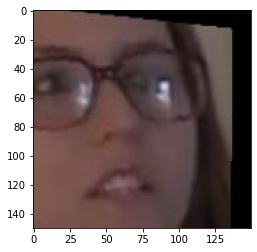

In [41]:
for filename in glob.glob('reduced_dataset/cropped_real_augmented/face_501.jpg'): 
    img=Image.open(filename)
    imgplot = plt.imshow(img)
    plt.show()